In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from variable_names import to_keep
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets


from preprocessing_pipeline import test_train_time_split, make_pipeline

In [2]:
### Here we make some arguments about why we drop certain variables

## Fill in later


In [3]:
df = pd.read_csv('data/Train.csv')
df = df[to_keep]

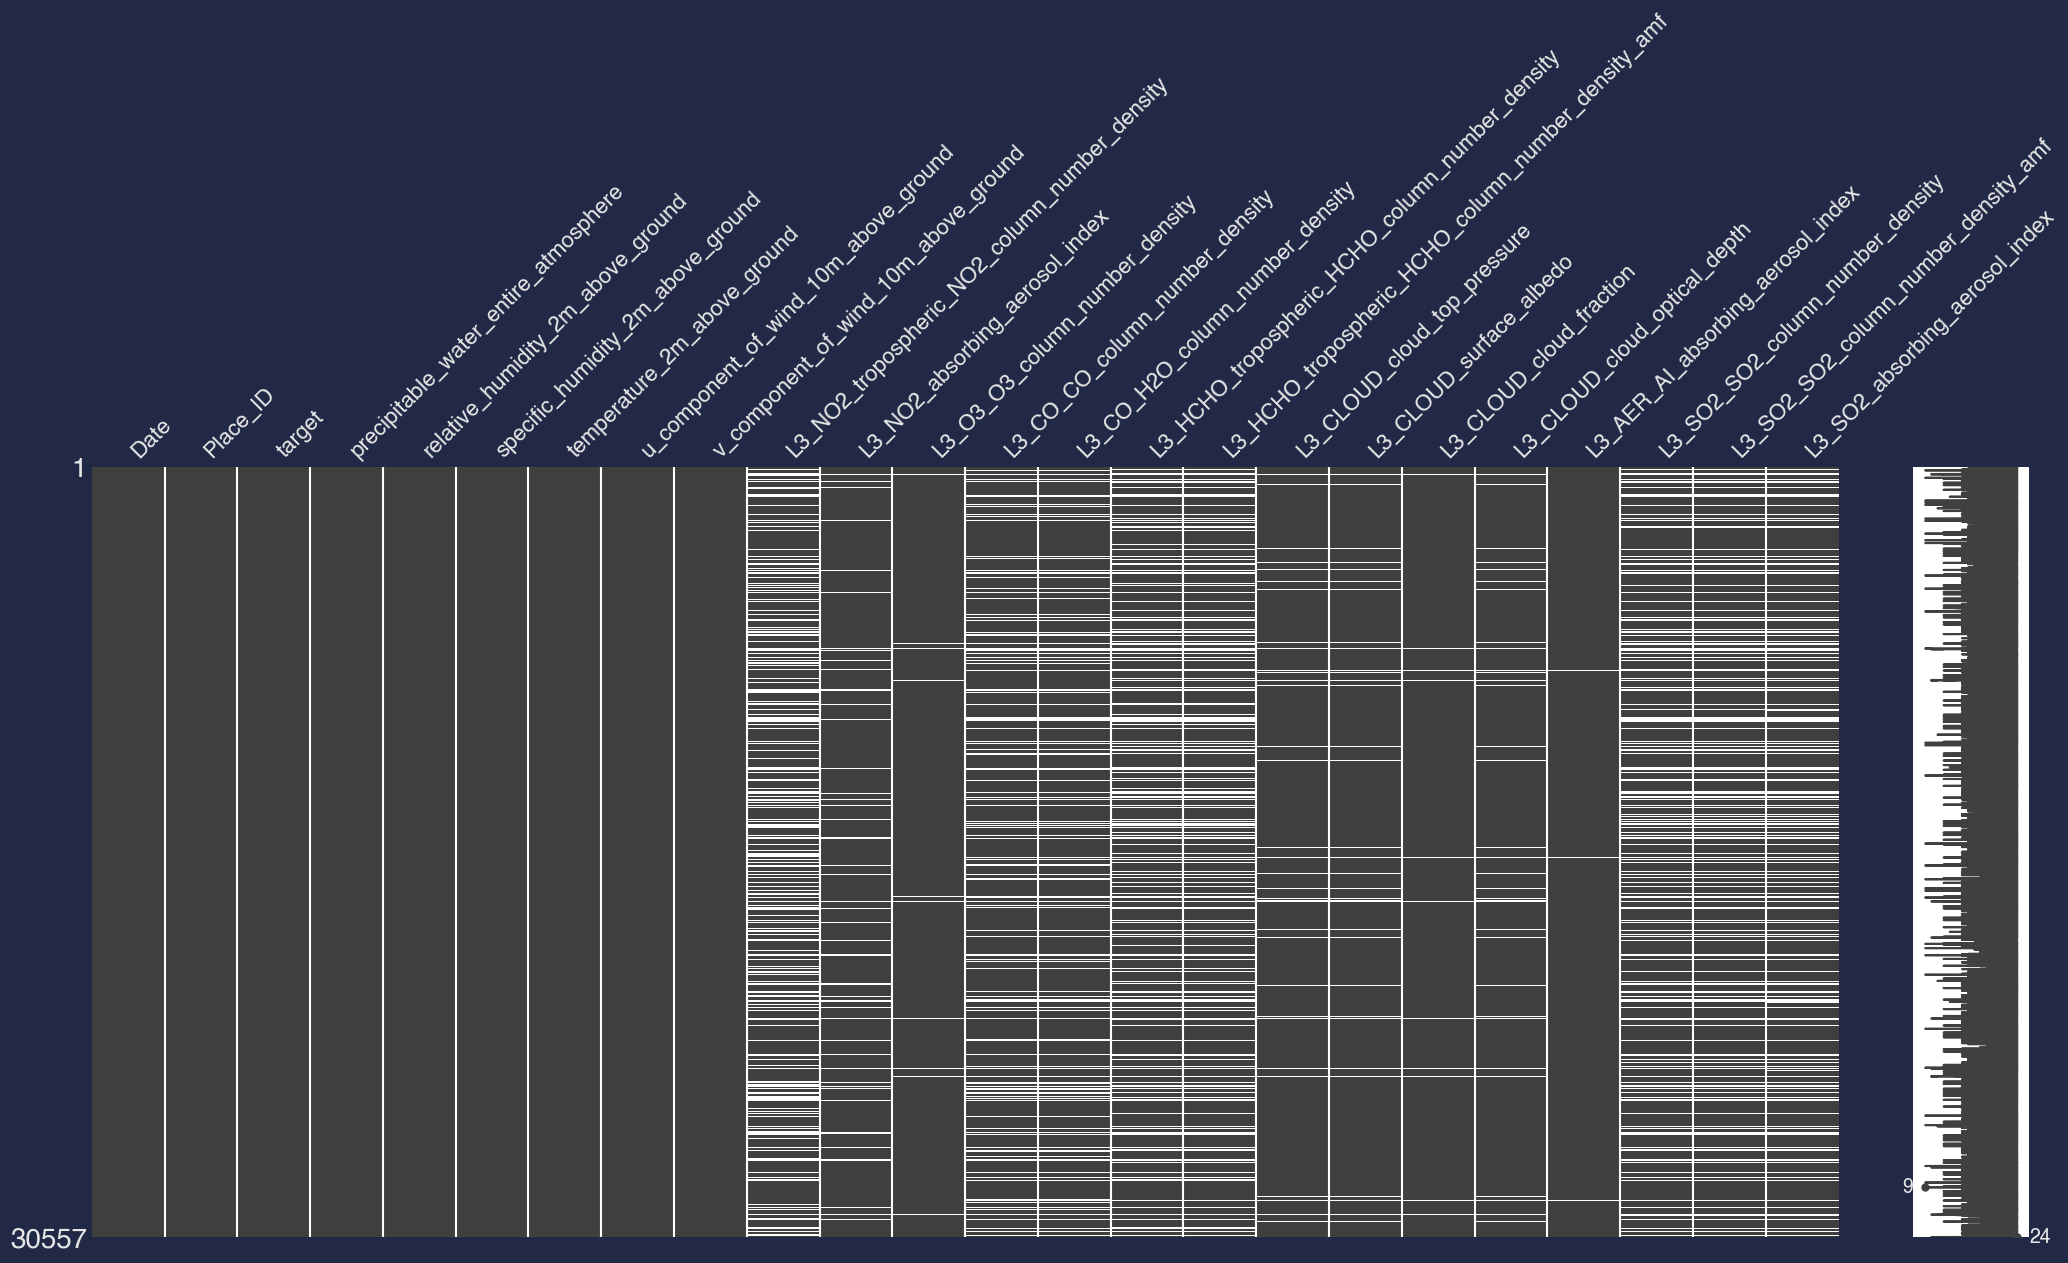

In [4]:
msno.matrix(df);

## Test train split for time-series data

In [5]:
#Perform test train split for time series data
X_train, X_test, y_train, y_test = test_train_time_split(data=df,
                                                         target_name='target',
                                                         date_name='Date',
                                                         test_size=0.3)

## Data Preprocessing Pipepline, without standardisation

In [8]:
qnt_cols = [col for col in to_keep if col not in ['Place_ID','Date','target']]
cat_cols = ['Place_ID']

preprocessor = make_pipeline(qnt_cols,cat_cols)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
## Later I want to do a fillna with local mean based on Place_ID